In [1]:
# %% 固定壁面温度的一维稳态计算

# % 参数设置
# L = 0.24;          % 墙体的厚度，单位为米 (240mm)
# W = 1.0;           % 墙体的长度，单位为米 (1000mm)
# alpha = 2.5*10^(-6);      % 热扩散率，单位为平方米每秒
# T0 = 20;           % x=0处的温度，单位为摄氏度
# TL = 40;           % x=L处的温度，单位为摄氏度
# Ti = 25;           % 初始平均温度，单位为摄氏度

# % 计算温度分布
# x = linspace(0, L, 100); % 在墙的厚度方向生成100个点以计算温度分布
# T = T0 + (TL - T0) * (x / L); % 线性温度分布计算

In [2]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6  # Thermal diffusivity of the soil in m^2/s
# T0 = 20        # Initial surface temperature in Celsius
# T1 = 40        # Surface temperature after change in Celsius
# L = 4          # Calculation thickness in meters
# dx = 0.1       # Spatial step in meters
# dt = 1800      # Time step in seconds
# tMax = 86400   # Simulation duration in seconds (1 day)
# W = 30         # Image width for plotting in meters

# # Time and space grid
# x = np.arange(0, L + dx, dx)  # Space grid
# t = np.arange(dt, tMax + dt, dt)  # Time grid, start from dt to avoid divide by zero

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Normalize the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# x_mean = np.mean(x_data, axis=0)
# x_std = np.std(x_data, axis=0) + 1e-8  # Add small constant to avoid division by zero
# x_data_norm = (x_data - x_mean) / x_std

# y_mean = np.mean(y_data)
# y_std = np.std(y_data) + 1e-8  # Add small constant to avoid division by zero
# y_data_norm = (y_data - y_mean) / y_std

# # Convert to tensors
# x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
# y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Initialize KAN with adjusted parameters
# model = KAN(width=[2, 10, 1], grid=20, k=3, seed=0)  # Input layer now has 2 neurons

# # Plot KAN at initialization
# model(dataset['train_input'])
# model.plot(beta=100)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Train the model with early stopping and learning rate scheduling
# train_with_early_stopping(model, dataset, steps=500, patience=100, initial_lr=0.0025)

# # Plot trained KAN
# model.plot()

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()
# # # Continue training to almost machine precision with conservative settings
# # train_with_early_stopping(model, dataset, steps=200, patience=50, initial_lr=0.00001)

# # Obtain the symbolic formula in terms of normalized data
# symbolic_formula_normalized = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula (Normalized):")
# print(symbolic_formula_normalized)

# # Reverse normalization for symbolic formula using sympy
# x_sym, t_sym = symbols('x t')
# normalized_formula = sympify(symbolic_formula_normalized)

# # Replace normalized variables with original scale variables
# original_formula = normalized_formula * (y_std / x_std[0]) + (y_mean - y_std / x_std[0] * x_mean[0])

# print("Discovered Symbolic Formula (Original):")
# print(original_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_norm = (x_test - x_mean) / x_std
# x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()
# predicted_temperature = predicted_temperature * y_std + y_mean  # Denormalize the prediction

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()


In [3]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6  # Thermal diffusivity of the soil in m^2/s
# T0 = 20        # Initial surface temperature in Celsius
# T1 = 40        # Surface temperature after change in Celsius
# L = 4          # Calculation thickness in meters
# dx = 0.1       # Spatial step in meters
# dt = 1800      # Time step in seconds
# tMax = 86400   # Simulation duration in seconds (1 day)
# W = 30         # Image width for plotting in meters

# # Time and space grid
# x = np.arange(0, L + dx, dx)  # Space grid
# t = np.arange(dt, tMax + dt, dt)  # Time grid, start from dt to avoid divide by zero

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Prepare the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# # Convert to tensors
# x_tensor = torch.tensor(x_data, dtype=torch.float32)
# y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Initialize KAN with adjusted parameters
# model = KAN(width=[2, 20, 1], grid=20, k=3, seed=0)  # Input layer now has 2 neurons

# # Plot KAN at initialization
# model(dataset['train_input'])
# model.plot(beta=100)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Train the model with early stopping and learning rate scheduling
# train_with_early_stopping(model, dataset, steps=500, patience=100, initial_lr=0.0025)

# # Plot trained KAN
# model.plot()

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()
# # # Continue training to almost machine precision with conservative settings
# # train_with_early_stopping(model, dataset, steps=200, patience=50, initial_lr=0.00001)

# # Obtain the symbolic formula
# symbolic_formula = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula:")
# print(symbolic_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()


In [4]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6
# T0 = 20
# T1 = 40
# L = 4
# dx = 0.1
# dt = 1800
# tMax = 86400
# W = 30

# # Time and space grid
# x = np.arange(0, L + dx, dx)
# t = np.arange(dt, tMax + dt, dt)

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Prepare the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# # Convert to tensors
# x_tensor = torch.tensor(x_data, dtype=torch.float32)
# y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Initial training with a coarse grid
# initial_grid = 3
# model = KAN(width=[2, 2, 2, 1], grid=initial_grid, k=3, seed=0)
# train_with_early_stopping(model, dataset, steps=1000, patience=100, initial_lr=0.002)

# # Iteratively refine the grid and retrain the model
# grids = [5, 10, 20, 50, 100]
# train_losses = []
# test_losses = []

# for grid in grids:
#     new_model = KAN(width=[2, 2, 2, 1], grid=grid, k=3).initialize_from_another_model(model, dataset['train_input'])
#     train_with_early_stopping(new_model, dataset, steps=500, patience=100, initial_lr=0.00005)
#     model = new_model  # Update the model to the new refined grid model

#     # Collect training and test losses
#     with torch.no_grad():
#         train_outputs = model(dataset['train_input'])
#         train_loss = torch.nn.functional.mse_loss(train_outputs, dataset['train_label']).item()
#         test_outputs = model(dataset['test_input'])
#         test_loss = torch.nn.functional.mse_loss(test_outputs, dataset['test_label']).item()
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()

# # Obtain the symbolic formula
# symbolic_formula = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula:")
# print(symbolic_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()

# # Plot training and test losses over different grid refinements
# plt.figure()
# plt.plot(grids, train_losses, marker='o', label='Train Loss')
# plt.plot(grids, test_losses, marker='o', label='Test Loss')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Grid Size')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.title('Training and Test Losses over Grid Refinements')
# plt.show()


Step 1/1000, Loss: 1.006316065788269, Validation Loss: 1.371787428855896
Step 2/1000, Loss: 1.0023128986358643, Validation Loss: 1.359310269355774
Step 3/1000, Loss: 0.9985527396202087, Validation Loss: 1.3476669788360596
Step 4/1000, Loss: 0.9950290322303772, Validation Loss: 1.3368865251541138
Step 5/1000, Loss: 0.9917342066764832, Validation Loss: 1.3269546031951904
Step 6/1000, Loss: 0.9886600375175476, Validation Loss: 1.3178017139434814
Step 7/1000, Loss: 0.9857967495918274, Validation Loss: 1.3093459606170654
Step 8/1000, Loss: 0.9831345081329346, Validation Loss: 1.301518440246582
Step 9/1000, Loss: 0.9806627631187439, Validation Loss: 1.294265866279602
Step 10/1000, Loss: 0.9783706068992615, Validation Loss: 1.2875436544418335
Step 11/1000, Loss: 0.97624671459198, Validation Loss: 1.2813127040863037
Step 12/1000, Loss: 0.9742792844772339, Validation Loss: 1.2755358219146729
Step 13/1000, Loss: 0.9724573493003845, Validation Loss: 1.2701786756515503
Step 14/1000, Loss: 0.970769

Step 116/1000, Loss: 0.8897001147270203, Validation Loss: 1.114662528038025
Step 117/1000, Loss: 0.8875318765640259, Validation Loss: 1.1117775440216064
Step 118/1000, Loss: 0.8852999806404114, Validation Loss: 1.1088236570358276
Step 119/1000, Loss: 0.8830040097236633, Validation Loss: 1.1058006286621094
Step 120/1000, Loss: 0.8806434869766235, Validation Loss: 1.102708101272583
Step 121/1000, Loss: 0.878217875957489, Validation Loss: 1.0995458364486694
Step 122/1000, Loss: 0.8757271766662598, Validation Loss: 1.0963135957717896
Step 123/1000, Loss: 0.8731709718704224, Validation Loss: 1.0930109024047852
Step 124/1000, Loss: 0.8705492615699768, Validation Loss: 1.0896377563476562
Step 125/1000, Loss: 0.8678617477416992, Validation Loss: 1.086193561553955
Step 126/1000, Loss: 0.8651086091995239, Validation Loss: 1.0826783180236816
Step 127/1000, Loss: 0.8622896671295166, Validation Loss: 1.079092025756836
Step 128/1000, Loss: 0.8594049215316772, Validation Loss: 1.0754340887069702
Step

Step 225/1000, Loss: 0.4491972327232361, Validation Loss: 0.5520938634872437
Step 226/1000, Loss: 0.4468945562839508, Validation Loss: 0.5491279363632202
Step 227/1000, Loss: 0.444607675075531, Validation Loss: 0.5461750626564026
Step 228/1000, Loss: 0.4423365592956543, Validation Loss: 0.5432354807853699
Step 229/1000, Loss: 0.44008100032806396, Validation Loss: 0.5403094291687012
Step 230/1000, Loss: 0.4378410875797272, Validation Loss: 0.5373971462249756
Step 231/1000, Loss: 0.43561652302742004, Validation Loss: 0.5344990491867065
Step 232/1000, Loss: 0.43340733647346497, Validation Loss: 0.5316153764724731
Step 233/1000, Loss: 0.4312133491039276, Validation Loss: 0.528746485710144
Step 234/1000, Loss: 0.4290345311164856, Validation Loss: 0.5258926153182983
Step 235/1000, Loss: 0.42687076330184937, Validation Loss: 0.5230541229248047
Step 236/1000, Loss: 0.4247218668460846, Validation Loss: 0.5202312469482422
Step 237/1000, Loss: 0.4225878119468689, Validation Loss: 0.51742422580718

Step 336/1000, Loss: 0.2890992760658264, Validation Loss: 0.3449435532093048
Step 337/1000, Loss: 0.28850045800209045, Validation Loss: 0.34420961141586304
Step 338/1000, Loss: 0.28790369629859924, Validation Loss: 0.3434787094593048
Step 339/1000, Loss: 0.28730908036231995, Validation Loss: 0.3427506387233734
Step 340/1000, Loss: 0.28671643137931824, Validation Loss: 0.3420255184173584
Step 341/1000, Loss: 0.2861258387565613, Validation Loss: 0.3413033187389374
Step 342/1000, Loss: 0.2855372726917267, Validation Loss: 0.3405839800834656
Step 343/1000, Loss: 0.28495073318481445, Validation Loss: 0.33986756205558777
Step 344/1000, Loss: 0.2843661606311798, Validation Loss: 0.3391540050506592
Step 345/1000, Loss: 0.28378358483314514, Validation Loss: 0.3384433090686798
Step 346/1000, Loss: 0.2832029461860657, Validation Loss: 0.33773547410964966
Step 347/1000, Loss: 0.2826242744922638, Validation Loss: 0.33703047037124634
Step 348/1000, Loss: 0.2820475697517395, Validation Loss: 0.336328

Step 444/1000, Loss: 0.24366487562656403, Validation Loss: 0.29129037261009216
Step 445/1000, Loss: 0.24343906342983246, Validation Loss: 0.29103389382362366
Step 446/1000, Loss: 0.24321365356445312, Validation Loss: 0.29077786207199097
Step 447/1000, Loss: 0.24298857152462006, Validation Loss: 0.29052236676216125
Step 448/1000, Loss: 0.24276380240917206, Validation Loss: 0.29026737809181213
Step 449/1000, Loss: 0.2425394058227539, Validation Loss: 0.29001280665397644
Step 450/1000, Loss: 0.2423153519630432, Validation Loss: 0.2897588610649109
Step 451/1000, Loss: 0.24209162592887878, Validation Loss: 0.28950536251068115
Step 452/1000, Loss: 0.24186822772026062, Validation Loss: 0.289252370595932
Step 453/1000, Loss: 0.2416451871395111, Validation Loss: 0.28899988532066345
Step 454/1000, Loss: 0.24142244458198547, Validation Loss: 0.2887479066848755
Step 455/1000, Loss: 0.24120007455348969, Validation Loss: 0.2884964048862457
Step 456/1000, Loss: 0.24097801744937897, Validation Loss: 0

Step 555/1000, Loss: 0.22572720050811768, Validation Loss: 0.2714473009109497
Step 556/1000, Loss: 0.22562766075134277, Validation Loss: 0.2713392376899719
Step 557/1000, Loss: 0.22552824020385742, Validation Loss: 0.27123120427131653
Step 558/1000, Loss: 0.22542884945869446, Validation Loss: 0.27112334966659546
Step 559/1000, Loss: 0.22532951831817627, Validation Loss: 0.2710154950618744
Step 560/1000, Loss: 0.22523029148578644, Validation Loss: 0.27090781927108765
Step 561/1000, Loss: 0.22513112425804138, Validation Loss: 0.27080029249191284
Step 562/1000, Loss: 0.2250320315361023, Validation Loss: 0.27069273591041565
Step 563/1000, Loss: 0.2249329835176468, Validation Loss: 0.2705853581428528
Step 564/1000, Loss: 0.22483401000499725, Validation Loss: 0.27047809958457947
Step 565/1000, Loss: 0.22473512589931488, Validation Loss: 0.27037087082862854
Step 566/1000, Loss: 0.2246362864971161, Validation Loss: 0.27026376128196716
Step 567/1000, Loss: 0.22453752160072327, Validation Loss: 

Step 662/1000, Loss: 0.21826228499412537, Validation Loss: 0.2634683847427368
Step 663/1000, Loss: 0.21821506321430206, Validation Loss: 0.26341813802719116
Step 664/1000, Loss: 0.21816790103912354, Validation Loss: 0.2633679509162903
Step 665/1000, Loss: 0.2181207686662674, Validation Loss: 0.263317734003067
Step 666/1000, Loss: 0.21807359158992767, Validation Loss: 0.2632676362991333
Step 667/1000, Loss: 0.21802644431591034, Validation Loss: 0.2632174789905548
Step 668/1000, Loss: 0.2179793119430542, Validation Loss: 0.2631673514842987
Step 669/1000, Loss: 0.21793219447135925, Validation Loss: 0.2631171643733978
Step 670/1000, Loss: 0.2178850620985031, Validation Loss: 0.2630670666694641
Step 671/1000, Loss: 0.21783795952796936, Validation Loss: 0.2630169689655304
Step 672/1000, Loss: 0.2177909016609192, Validation Loss: 0.2629668712615967
Step 673/1000, Loss: 0.21774382889270782, Validation Loss: 0.26291680335998535
Step 674/1000, Loss: 0.21769681572914124, Validation Loss: 0.262866

Step 772/1000, Loss: 0.21476125717163086, Validation Loss: 0.25978219509124756
Step 773/1000, Loss: 0.2147381752729416, Validation Loss: 0.2597578167915344
Step 774/1000, Loss: 0.21471509337425232, Validation Loss: 0.2597334384918213
Step 775/1000, Loss: 0.21469199657440186, Validation Loss: 0.25970908999443054
Step 776/1000, Loss: 0.2146688997745514, Validation Loss: 0.2596847116947174
Step 777/1000, Loss: 0.21464583277702332, Validation Loss: 0.2596603333950043
Step 778/1000, Loss: 0.21462272107601166, Validation Loss: 0.2596360146999359
Step 779/1000, Loss: 0.21459966897964478, Validation Loss: 0.2596116364002228
Step 780/1000, Loss: 0.21457655727863312, Validation Loss: 0.2595873177051544
Step 781/1000, Loss: 0.21455349028110504, Validation Loss: 0.2595629096031189
Step 782/1000, Loss: 0.21453039348125458, Validation Loss: 0.2595386505126953
Step 783/1000, Loss: 0.2145073413848877, Validation Loss: 0.25951430201530457
Step 784/1000, Loss: 0.2144842892885208, Validation Loss: 0.2594

Step 883/1000, Loss: 0.21313883364200592, Validation Loss: 0.25808435678482056
Step 884/1000, Loss: 0.21312737464904785, Validation Loss: 0.2580723464488983
Step 885/1000, Loss: 0.21311591565608978, Validation Loss: 0.2580602467060089
Step 886/1000, Loss: 0.21310444176197052, Validation Loss: 0.2580481469631195
Step 887/1000, Loss: 0.21309296786785126, Validation Loss: 0.2580361068248749
Step 888/1000, Loss: 0.2130814492702484, Validation Loss: 0.2580240070819855
Step 889/1000, Loss: 0.21306999027729034, Validation Loss: 0.25801193714141846
Step 890/1000, Loss: 0.21305853128433228, Validation Loss: 0.25799989700317383
Step 891/1000, Loss: 0.21304701268672943, Validation Loss: 0.2579878568649292
Step 892/1000, Loss: 0.21303556859493256, Validation Loss: 0.2579757869243622
Step 893/1000, Loss: 0.2130240947008133, Validation Loss: 0.25796371698379517
Step 894/1000, Loss: 0.21301259100437164, Validation Loss: 0.25795167684555054
Step 895/1000, Loss: 0.21300114691257477, Validation Loss: 0.

Step 991/1000, Loss: 0.21240882575511932, Validation Loss: 0.25732114911079407
Step 992/1000, Loss: 0.2124030739068985, Validation Loss: 0.25731509923934937
Step 993/1000, Loss: 0.21239730715751648, Validation Loss: 0.25730904936790466
Step 994/1000, Loss: 0.21239157021045685, Validation Loss: 0.25730299949645996
Step 995/1000, Loss: 0.21238580346107483, Validation Loss: 0.25729694962501526
Step 996/1000, Loss: 0.2123800814151764, Validation Loss: 0.25729089975357056
Step 997/1000, Loss: 0.21237431466579437, Validation Loss: 0.25728487968444824
Step 998/1000, Loss: 0.21236859261989594, Validation Loss: 0.2572788596153259
Step 999/1000, Loss: 0.2123628556728363, Validation Loss: 0.25727272033691406
Step 1000/1000, Loss: 0.21235708892345428, Validation Loss: 0.25726667046546936
Step 1/1000, Loss: 0.3244418799877167, Validation Loss: 0.6476433277130127
Step 2/1000, Loss: 0.31811287999153137, Validation Loss: 0.6444289088249207
Step 3/1000, Loss: 0.31247231364250183, Validation Loss: 0.639

Step 103/1000, Loss: 0.1055769994854927, Validation Loss: 0.5050041079521179
Step 104/1000, Loss: 0.10479588806629181, Validation Loss: 0.5001338124275208
Step 105/1000, Loss: 0.10401694476604462, Validation Loss: 0.49519506096839905
Step 106/1000, Loss: 0.10324007272720337, Validation Loss: 0.4902012348175049
Step 107/1000, Loss: 0.10246524959802628, Validation Loss: 0.4851674437522888
Step 108/1000, Loss: 0.10169242322444916, Validation Loss: 0.48010969161987305
Step 109/1000, Loss: 0.10092156380414963, Validation Loss: 0.4750438928604126
Step 110/1000, Loss: 0.10015261173248291, Validation Loss: 0.46998533606529236
Step 111/1000, Loss: 0.09938555210828781, Validation Loss: 0.46494850516319275
Step 112/1000, Loss: 0.09862038493156433, Validation Loss: 0.4599459767341614
Step 113/1000, Loss: 0.09785706549882889, Validation Loss: 0.45498931407928467
Step 114/1000, Loss: 0.09709560126066208, Validation Loss: 0.4500870406627655
Step 115/1000, Loss: 0.09633592516183853, Validation Loss: 0

Step 209/1000, Loss: 0.037368740886449814, Validation Loss: 0.2048107236623764
Step 210/1000, Loss: 0.0371265783905983, Validation Loss: 0.20418983697891235
Step 211/1000, Loss: 0.03688603639602661, Validation Loss: 0.2035733163356781
Step 212/1000, Loss: 0.036647114902734756, Validation Loss: 0.20296071469783783
Step 213/1000, Loss: 0.036409784108400345, Validation Loss: 0.2023514062166214
Step 214/1000, Loss: 0.036174021661281586, Validation Loss: 0.20174500346183777
Step 215/1000, Loss: 0.03593980520963669, Validation Loss: 0.20114107429981232
Step 216/1000, Loss: 0.03570712357759476, Validation Loss: 0.20053908228874207
Step 217/1000, Loss: 0.0354759581387043, Validation Loss: 0.19993871450424194
Step 218/1000, Loss: 0.03524630516767502, Validation Loss: 0.19933977723121643
Step 219/1000, Loss: 0.03501814603805542, Validation Loss: 0.19874192774295807
Step 220/1000, Loss: 0.03479146584868431, Validation Loss: 0.19814519584178925
Step 221/1000, Loss: 0.0345662422478199, Validation L

Step 316/1000, Loss: 0.01969023048877716, Validation Loss: 0.15478774905204773
Step 317/1000, Loss: 0.019629817456007004, Validation Loss: 0.15463681519031525
Step 318/1000, Loss: 0.019569629803299904, Validation Loss: 0.15448716282844543
Step 319/1000, Loss: 0.01950964517891407, Validation Loss: 0.1543387621641159
Step 320/1000, Loss: 0.019449880346655846, Validation Loss: 0.15419167280197144
Step 321/1000, Loss: 0.01939031295478344, Validation Loss: 0.15404580533504486
Step 322/1000, Loss: 0.019330959767103195, Validation Loss: 0.15390117466449738
Step 323/1000, Loss: 0.019271811470389366, Validation Loss: 0.15375782549381256
Step 324/1000, Loss: 0.01921285130083561, Validation Loss: 0.15361569821834564
Step 325/1000, Loss: 0.019154103472828865, Validation Loss: 0.153474822640419
Step 326/1000, Loss: 0.019095545634627342, Validation Loss: 0.15333516895771027
Step 327/1000, Loss: 0.019037185236811638, Validation Loss: 0.15319673717021942
Step 328/1000, Loss: 0.018979022279381752, Vali

Step 421/1000, Loss: 0.014744962565600872, Validation Loss: 0.145219624042511
Step 422/1000, Loss: 0.014723074622452259, Validation Loss: 0.1451898217201233
Step 423/1000, Loss: 0.014701222069561481, Validation Loss: 0.14516007900238037
Step 424/1000, Loss: 0.014679394662380219, Validation Loss: 0.1451304703950882
Step 425/1000, Loss: 0.014657599851489067, Validation Loss: 0.14510101079940796
Step 426/1000, Loss: 0.014635849744081497, Validation Loss: 0.14507173001766205
Step 427/1000, Loss: 0.014614117331802845, Validation Loss: 0.1450425386428833
Step 428/1000, Loss: 0.014592424035072327, Validation Loss: 0.1450134664773941
Step 429/1000, Loss: 0.014570754021406174, Validation Loss: 0.1449843794107437
Step 430/1000, Loss: 0.01454912405461073, Validation Loss: 0.14495554566383362
Step 431/1000, Loss: 0.014527522958815098, Validation Loss: 0.14492680132389069
Step 432/1000, Loss: 0.014505944214761257, Validation Loss: 0.1448982059955597
Step 433/1000, Loss: 0.014484409242868423, Valida

Step 528/1000, Loss: 0.012820773757994175, Validation Loss: 0.14288994669914246
Step 529/1000, Loss: 0.012811213731765747, Validation Loss: 0.14287956058979034
Step 530/1000, Loss: 0.01280166395008564, Validation Loss: 0.14286914467811584
Step 531/1000, Loss: 0.012792116031050682, Validation Loss: 0.14285868406295776
Step 532/1000, Loss: 0.012782569043338299, Validation Loss: 0.14284837245941162
Step 533/1000, Loss: 0.012773037888109684, Validation Loss: 0.14283795654773712
Step 534/1000, Loss: 0.012763497419655323, Validation Loss: 0.1428276151418686
Step 535/1000, Loss: 0.012753968127071857, Validation Loss: 0.14281721413135529
Step 536/1000, Loss: 0.012744439765810966, Validation Loss: 0.14280688762664795
Step 537/1000, Loss: 0.012734918855130672, Validation Loss: 0.1427965760231018
Step 538/1000, Loss: 0.012725399807095528, Validation Loss: 0.14278623461723328
Step 539/1000, Loss: 0.01271588634699583, Validation Loss: 0.14277595281600952
Step 540/1000, Loss: 0.012706381268799305, V

Step 633/1000, Loss: 0.011983984149992466, Validation Loss: 0.14200666546821594
Step 634/1000, Loss: 0.011979389935731888, Validation Loss: 0.14200197160243988
Step 635/1000, Loss: 0.011974801309406757, Validation Loss: 0.14199726283550262
Step 636/1000, Loss: 0.011970213614404202, Validation Loss: 0.14199258387088776
Step 637/1000, Loss: 0.011965620331466198, Validation Loss: 0.1419878900051117
Step 638/1000, Loss: 0.011961031705141068, Validation Loss: 0.14198321104049683
Step 639/1000, Loss: 0.011956444010138512, Validation Loss: 0.14197856187820435
Step 640/1000, Loss: 0.011951851658523083, Validation Loss: 0.14197389781475067
Step 641/1000, Loss: 0.011947260238230228, Validation Loss: 0.14196930825710297
Step 642/1000, Loss: 0.011942671611905098, Validation Loss: 0.1419646292924881
Step 643/1000, Loss: 0.011938086710870266, Validation Loss: 0.1419599950313568
Step 644/1000, Loss: 0.011933502741158009, Validation Loss: 0.14195528626441956
Step 645/1000, Loss: 0.011928913183510303, 

Step 739/1000, Loss: 0.011582596227526665, Validation Loss: 0.1416098177433014
Step 740/1000, Loss: 0.01158029306679964, Validation Loss: 0.1416076272726059
Step 741/1000, Loss: 0.011577987112104893, Validation Loss: 0.14160536229610443
Step 742/1000, Loss: 0.011575679294764996, Validation Loss: 0.14160315692424774
Step 743/1000, Loss: 0.011573371477425098, Validation Loss: 0.14160096645355225
Step 744/1000, Loss: 0.0115710673853755, Validation Loss: 0.14159876108169556
Step 745/1000, Loss: 0.01156875491142273, Validation Loss: 0.14159660041332245
Step 746/1000, Loss: 0.011566445231437683, Validation Loss: 0.14159439504146576
Step 747/1000, Loss: 0.011564142070710659, Validation Loss: 0.14159224927425385
Step 748/1000, Loss: 0.011561824008822441, Validation Loss: 0.14159002900123596
Step 749/1000, Loss: 0.011559517122805119, Validation Loss: 0.14158786833286285
Step 750/1000, Loss: 0.011557205580174923, Validation Loss: 0.14158573746681213
Step 751/1000, Loss: 0.011554891243577003, Val

Step 844/1000, Loss: 0.011387024074792862, Validation Loss: 0.14143429696559906
Step 845/1000, Loss: 0.011385842226445675, Validation Loss: 0.14143326878547668
Step 846/1000, Loss: 0.01138465479016304, Validation Loss: 0.1414322555065155
Step 847/1000, Loss: 0.011383471079170704, Validation Loss: 0.14143125712871552
Step 848/1000, Loss: 0.011382287368178368, Validation Loss: 0.14143024384975433
Step 849/1000, Loss: 0.011381101794540882, Validation Loss: 0.14142924547195435
Step 850/1000, Loss: 0.011379910632967949, Validation Loss: 0.14142830669879913
Step 851/1000, Loss: 0.011378727853298187, Validation Loss: 0.14142729341983795
Step 852/1000, Loss: 0.011377543210983276, Validation Loss: 0.14142629504203796
Step 853/1000, Loss: 0.011376352049410343, Validation Loss: 0.14142532646656036
Step 854/1000, Loss: 0.011375165544450283, Validation Loss: 0.14142435789108276
Step 855/1000, Loss: 0.011373979039490223, Validation Loss: 0.14142341911792755
Step 856/1000, Loss: 0.011372788809239864,

Step 948/1000, Loss: 0.01128979679197073, Validation Loss: 0.14135929942131042
Step 949/1000, Loss: 0.01128918956965208, Validation Loss: 0.1413588970899582
Step 950/1000, Loss: 0.011288574896752834, Validation Loss: 0.14135850965976715
Step 951/1000, Loss: 0.011287963017821312, Validation Loss: 0.14135806262493134
Step 952/1000, Loss: 0.011287348344922066, Validation Loss: 0.14135761559009552
Step 953/1000, Loss: 0.011286738328635693, Validation Loss: 0.14135724306106567
Step 954/1000, Loss: 0.011286123655736446, Validation Loss: 0.14135679602622986
Step 955/1000, Loss: 0.011285508051514626, Validation Loss: 0.14135637879371643
Step 956/1000, Loss: 0.01128489337861538, Validation Loss: 0.1413559913635254
Step 957/1000, Loss: 0.01128427404910326, Validation Loss: 0.14135555922985077
Step 958/1000, Loss: 0.011283661238849163, Validation Loss: 0.14135517179965973
Step 959/1000, Loss: 0.011283048428595066, Validation Loss: 0.1413547545671463
Step 960/1000, Loss: 0.011282437480986118, Vali

Step 57/1000, Loss: 0.10881951451301575, Validation Loss: 0.11314818263053894
Step 58/1000, Loss: 0.1067488044500351, Validation Loss: 0.10932134091854095
Step 59/1000, Loss: 0.10474000126123428, Validation Loss: 0.10593143850564957
Step 60/1000, Loss: 0.10279810428619385, Validation Loss: 0.10301214456558228
Step 61/1000, Loss: 0.10092800110578537, Validation Loss: 0.10058228671550751
Step 62/1000, Loss: 0.0991363525390625, Validation Loss: 0.098641537129879
Step 63/1000, Loss: 0.09743265062570572, Validation Loss: 0.09716503322124481
Step 64/1000, Loss: 0.0958278626203537, Validation Loss: 0.09610390663146973
Step 65/1000, Loss: 0.09433130919933319, Validation Loss: 0.0953914076089859
Step 66/1000, Loss: 0.09294735640287399, Validation Loss: 0.09494929760694504
Step 67/1000, Loss: 0.09167345613241196, Validation Loss: 0.09469197690486908
Step 68/1000, Loss: 0.09050016850233078, Validation Loss: 0.09453369677066803
Step 69/1000, Loss: 0.08941370248794556, Validation Loss: 0.0944030657

Step 164/1000, Loss: 0.05243400111794472, Validation Loss: 0.12462031096220016
Step 165/1000, Loss: 0.052308470010757446, Validation Loss: 0.1249522939324379
Step 166/1000, Loss: 0.05218540132045746, Validation Loss: 0.12528014183044434
Step 167/1000, Loss: 0.05206475406885147, Validation Loss: 0.1256035566329956
Step 168/1000, Loss: 0.05194643512368202, Validation Loss: 0.12592217326164246
Step 169/1000, Loss: 0.05183041840791702, Validation Loss: 0.1262354999780655
Step 170/1000, Loss: 0.0517166368663311, Validation Loss: 0.12654338777065277
Step 171/1000, Loss: 0.05160503461956978, Validation Loss: 0.1268458068370819
Step 172/1000, Loss: 0.051495566964149475, Validation Loss: 0.12714308500289917
Step 173/1000, Loss: 0.051388174295425415, Validation Loss: 0.12743566930294037
Step 174/1000, Loss: 0.05128280445933342, Validation Loss: 0.12772409617900848
Step 175/1000, Loss: 0.05117940530180931, Validation Loss: 0.12800872325897217
Step 176/1000, Loss: 0.05107791721820831, Validation L

Step 92/1000, Loss: 0.1638801544904709, Validation Loss: 0.22594967484474182
Step 93/1000, Loss: 0.16205236315727234, Validation Loss: 0.22575229406356812
Step 94/1000, Loss: 0.1602364480495453, Validation Loss: 0.22617006301879883
Step 95/1000, Loss: 0.15924878418445587, Validation Loss: 0.22544771432876587
Step 96/1000, Loss: 0.15706472098827362, Validation Loss: 0.22478286921977997
Step 97/1000, Loss: 0.1559199094772339, Validation Loss: 0.22521553933620453
Step 98/1000, Loss: 0.1539747565984726, Validation Loss: 0.2246689349412918
Step 99/1000, Loss: 0.1521238088607788, Validation Loss: 0.22441257536411285
Step 100/1000, Loss: 0.15051299333572388, Validation Loss: 0.22498853504657745
Step 101/1000, Loss: 0.14903046190738678, Validation Loss: 0.22415801882743835
Step 102/1000, Loss: 0.14677850902080536, Validation Loss: 0.2240181714296341
Step 103/1000, Loss: 0.14584513008594513, Validation Loss: 0.224173903465271
Step 104/1000, Loss: 0.14487574994564056, Validation Loss: 0.22407454

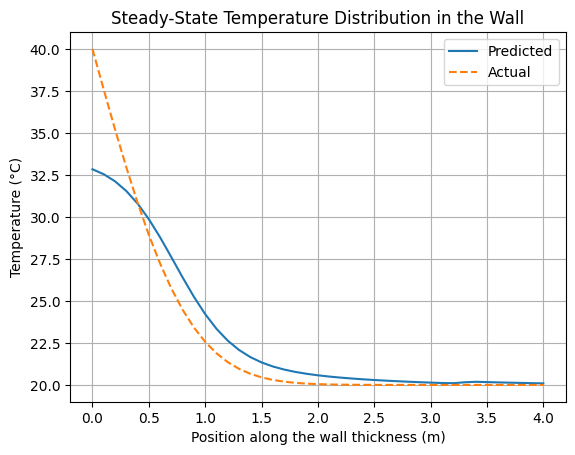

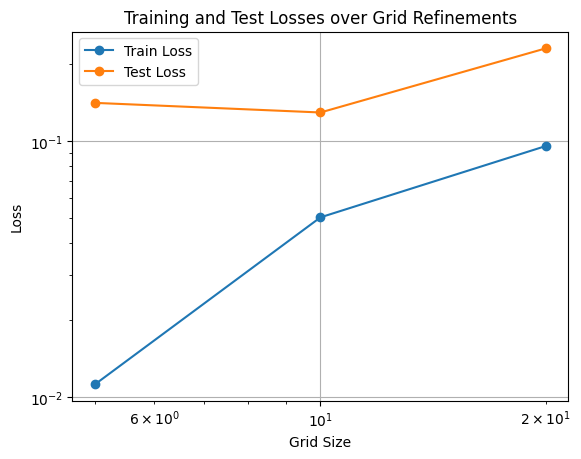

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sympy import symbols, sympify
from scipy.special import erfc
from kan import KAN, add_symbolic, create_dataset

# Parameters
alpha = 2.5e-6
T0 = 20
T1 = 40
L = 4
dx = 0.1
dt = 1800
tMax = 86400
W = 30

# Time and space grid
x = np.arange(0, L + dx, dx)
t = np.arange(dt, tMax + dt, dt)

# Initialize temperature data storage
TemperatureData = np.zeros((len(t), len(x)))

# Compute temperature distribution and store results
for k in range(len(t)):
    TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# Prepare the data
x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
y_data = TemperatureData.flatten()

# # Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data)
y_std = np.std(y_data)

x_data_normalized = (x_data - x_mean) / x_std
y_data_normalized = (y_data - y_mean) / y_std
# x_data_normalized = x_data
# y_data_normalized = y_data

# Convert to tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32).unsqueeze(1)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Add erfc to the symbolic library
add_symbolic('erfc', torch.special.erfc)

# Function to train KAN with early stopping and learning rate scheduling
def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    criterion = torch.nn.MSELoss()

    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    current_lr = initial_lr

    for step in range(steps):
        def closure():
            optimizer.zero_grad()
            outputs = model(dataset['train_input'])
            loss = criterion(outputs, dataset['train_label'])
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            return loss

        loss = optimizer.step(closure).item()

        # Validation step
        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = criterion(val_outputs, dataset['test_label']).item()

        print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Learning rate scheduling
        if step % patience == 0 and step > 0:
            current_lr = max(min_lr, current_lr * lr_decay)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

        # Check for NaN values
        if np.isnan(loss) or np.isnan(val_loss):
            print("NaN detected, stopping training")
            break

    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

# Initial training with a coarse grid
initial_grid = 3
model = KAN(width=[2, 2, 2, 1], grid=initial_grid, k=3, seed=0)
train_with_early_stopping(model, dataset, steps=1000, patience=100, initial_lr=0.002)

# Iteratively refine the grid and retrain the model
grids = [5, 10, 20]
train_losses = []
test_losses = []

for grid in grids:
    new_model = KAN(width=[2, 2, 2, 1], grid=grid, k=3).initialize_from_another_model(model, dataset['train_input'])
    train_with_early_stopping(new_model, dataset, steps=1000, patience=100, initial_lr=0.002)
    model = new_model  # Update the model to the new refined grid model

    # Collect training and test losses
    with torch.no_grad():
        train_outputs = model(dataset['train_input'])
        train_loss = torch.nn.functional.mse_loss(train_outputs, dataset['train_label']).item()
        test_outputs = model(dataset['test_input'])
        test_loss = torch.nn.functional.mse_loss(test_outputs, dataset['test_label']).item()
        train_losses.append(train_loss)
        test_losses.append(test_loss)

# Automatically set activation functions to be symbolic
lib = ['x', '1/sqrt(x)', 'erfc']
model.auto_symbolic(lib=lib)

# Prune the model
model = model.prune()

# Obtain the symbolic formula and denormalize it
symbolic_formula = model.symbolic_formula()[0][0]
# symbolic_formula_denormalized = sympify(symbolic_formula.replace('x_1', '(x_1*{:.6f}+{:.6f})'.format(x_std[0], x_mean[0]))
#                                         .replace('x_2', '(x_2*{:.6f}+{:.6f})'.format(x_std[1], x_mean[1])))
# symbolic_formula_denormalized = (symbolic_formula_denormalized * y_std + y_mean).simplify()

# print("Discovered Symbolic Formula:")
# print(symbolic_formula_denormalized)

# Create output directory for plots
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Plot predicted temperature distribution
x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
x_test_normalized = (x_test - x_mean) / x_std
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


predicted_temperature = model(x_test_tensor).detach().numpy().flatten() * y_std + y_mean
# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

plt.figure()
plt.plot(x, predicted_temperature, label='Predicted')
plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
plt.xlabel('Position along the wall thickness (m)')
plt.ylabel('Temperature (°C)')
plt.title('Steady-State Temperature Distribution in the Wall')
plt.legend()
plt.grid(True)
plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()

# Plot training and test losses over different grid refinements
plt.figure()
plt.plot(grids, train_losses, marker='o', label='Train Loss')
plt.plot(grids, test_losses, marker='o', label='Test Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grid Size')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Test Losses over Grid Refinements')
plt.show()


In [6]:
print("Discovered Symbolic Formula (Normalized):")
model.symbolic_formula()[0][0]

Discovered Symbolic Formula (Normalized):


-1.81*erfc(0.1*erfc(-2.85*erfc(9.88 - 8.02*x_1) + 84.78*erfc(1.46*x_2 - 0.2) - 0.92) - 0.25*erfc(0.12*erfc(9.0*x_2 - 10.0) - 2.58 + 2.28/sqrt(0.38*x_1 + 1)) - 0.58) - 1.22*erfc(-0.69*erfc(2.85*erfc(9.88 - 8.02*x_1) - 84.78*erfc(1.46*x_2 - 0.2) + 1.12) - 2.04*erfc(0.14*erfc(9.0*x_2 - 10.0) - 2.97 + 2.66/sqrt(0.38*x_1 + 1)) + 1.12) + 5.19

In [7]:
# print("Discovered Symbolic Formula (Original):")
# print(original_formula)